# Modellbildung und Simulation - Übung 1

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pylab as pylab
import math as math
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy.integrate as integrate
from scipy.optimize import least_squares

# Aufgabe 1 A - Fahrstuhl

Darstellung der gemessenen Daten aus dem Phyphox-Fahrstuhl-Experiment.

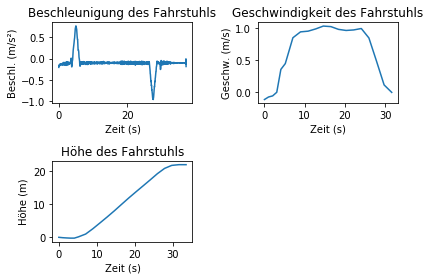

In [2]:
accData = pd.read_csv("data/Acceleration.csv", sep=";")
pvData = pd.read_csv("data/Pressure_and_velocity.csv", sep=";")

plt.subplot(221)
plt.title('Beschleunigung des Fahrstuhls')
plt.plot(accData['Time (s)'], accData['Acceleration (m/s²)'])
plt.ylabel('Beschl. (m/s²)')
plt.xlabel('Zeit (s)')
plt.subplot(222)
plt.title('Geschwindigkeit des Fahrstuhls')
plt.plot(pvData['Time (s)'], pvData['Velocity (m/s)'])
plt.ylabel('Geschw. (m/s)')
plt.xlabel('Zeit (s)')
plt.subplot(223)
plt.title('Höhe des Fahrstuhls')
plt.plot(pvData['Time (s)'], pvData['Height (m)'])
plt.ylabel('Höhe (m)')
plt.xlabel('Zeit (s)')
plt.tight_layout()

Anhand der gemessene Daten für die Beschleunigung kann eine Funktion zur Modellierung definiert werden.
Hierzu werden die maximale Beschleunigung $a_{max}$ sowie die Zeitpunkte der pos. und neg. Beschleunigung aus den Messdaten übernommen:

$$
a(t) = \begin{cases} 
           -a_{max} \cdot ( |(t-5)| - 1) & \text{if } 4 \leq x \geq 6 & (pos. Beschleunigung)\\
           a_{max} \cdot ( |(t-27,5| - 1) & \text{if } 26,5 \leq x \geq 28,5 & (neg. Beschleunigung)\\
           0       & sonst
      \end{cases}
$$

Des weiteren wurde, wie in dem oberen Plot der gem. Beschleunigung zu sehen, festgestellt, dass die Messung der Beschleunigung einem konstanten Fehler $e$ unterliegt. Dies ist besonders im Bereich der gleichbleibenden Geschwindigkeit zu sehen, wo die Messung der Beschleunigung nicht um den Nullpunkt schwankt, sondern um etwa $0.1$. Das lässt sich mit hoher Wahrscheinlichkeit auf eine Fehlerhafte Korrektur der stationären Geschwindigkeit durch die Erdanziehung erklären. Die Daten wurden dahingehen korrigiert. 

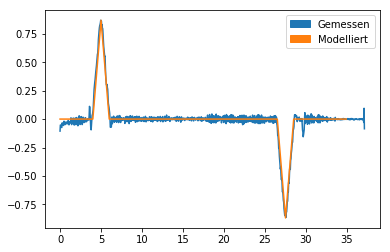

In [3]:
e = 0.1
a_max = max(accData['Acceleration (m/s²)']+e)
acc_time = 5
brake_time=27.5

plt.plot(accData['Time (s)'], accData['Acceleration (m/s²)']+0.1, color='C0')

acc_func = lambda t,acc_sign: a_max*-acc_sign*(abs(t)-1) #acc_sign = Sign for positiv or negetiv acceleration 
a_model = lambda t: acc_func(t-acc_time,1) if ( t>=acc_time-1 and t<=acc_time+1 ) else acc_func(t-brake_time,-1) if ( t>=brake_time-1 and t<=brake_time+1 ) else 0

plt.plot(np.arange(0, 35, 0.1), [a_model(x) for x in np.arange(0, 35, 0.1)], color='C1')

red_patch = mpatches.Patch(color='C0', label='Gemessen')
blue_patch = mpatches.Patch(color='C1', label='Modelliert')
plt.legend(handles=[red_patch, blue_patch])

Daraus kann die Funktion für die Geschwindigkeit über die Ableitung von $a(t)$ ermittelt werden.

$$
\dot{a}(t) = \frac{d}{dt} a(t)
$$

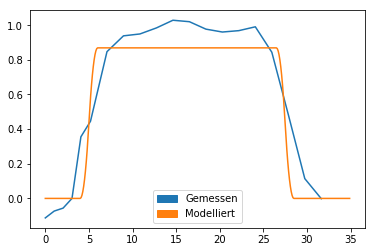

In [4]:
plt.plot(pvData['Time (s)'], pvData['Velocity (m/s)'], color='C0')

v_model = lambda t: integrate.quad(a_model, 0, t, full_output=True)[0]

plt.plot(np.arange(0, 35, 0.1), [v_model(x) for x in np.arange(0, 35, 0.1)], color='C1')

red_patch = mpatches.Patch(color='C0', label='Gemessen')
blue_patch = mpatches.Patch(color='C1', label='Modelliert')
plt.legend(handles=[red_patch, blue_patch])

Da die Messung der Geschwindigkeit nicht auf dem Beschleunigungssensor, sondern auf dem Barometer basiert, weicht das Modell stark von der Messung ab.

Analog zur Geschwindigkeit kann die Funktion für die Höhe über die 2. Ableitung von $a(t)$ ermittelt werden.

$$
\ddot{a}(t) = \frac{d}{dt^2} a(t)
$$

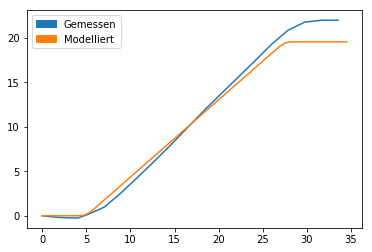

In [5]:
plt.plot(pvData['Time (s)'], pvData['Height (m)'], color='C0')

s_model = lambda t: integrate.quad(v_model, 0, t, full_output=True)[0]

#Takes up to 60 Sec
plt.plot(np.arange(0, 35, 0.5), [s_model(x) for x in np.arange(0, 35, 0.5)], color='C1')

red_patch = mpatches.Patch(color='C0', label='Gemessen')
blue_patch = mpatches.Patch(color='C1', label='Modelliert')
plt.legend(handles=[red_patch, blue_patch])

Wie schon bei der Geschwindigkeit weicht das Modell aufgrund der unterschiedlichen Messmethoden von der Messung ab.

Im Folgenden wird die Messung und das Modell als Animation gegenüber gestellt. Dabei basiert die Bewegung auf dem Modell und den gemessenen Daten für die Geschwindigkeit.

Die Bewegung basiert somit auf:
$$
s_0 = 0 \\
s(t) = s_{t-1} + v(t)*dt
$$

In [20]:
from vpython import *
scene = canvas(background=color.white) #vpython bug
max_height = 30;
start_time = 4
end_time = 28.5
s_0 = -max_height/2

e_model = box(pos=vector(s_0,-3,0), size=vector(5,5,0), color=color.red)
text(text='Modellierte Bewegung', pos=vector(s_0,-8,0), depth=0, color=color.red)
e_meas = box(pos=vector(s_0,3,0), size=vector(5,5,0), color=color.blue)
text(text='Gemessene Bewegung', pos=vector(s_0,8,0), depth=0, color=color.blue)

#Get the measured velocity at time t 
def meas_v(t):
    meas_i = 0
    while pvData['Time (s)'][meas_i] < t:
        meas_i += 1
    vel = pvData['Velocity (m/s)'][meas_i]
    return vel if vel >= 0 else 0

display(width=600,height=600,center=vector(-s_0,0,0))
t = 0;
step = 0.02
end = 28.5;
while t < end:
    rate(100)
    e_meas.v = vec(meas_v(t),0,0)
    e_model.v = vec(v_model(t),0,0)
    e_model.pos = e_model.pos + e_model.v*step
    e_meas.pos = e_meas.pos + e_meas.v*step
    t += step

<IPython.core.display.Javascript object>

# Aufgabe 1 B - Polyfit von Unbekannt

Im Folgenden werden die Unbekannten Daten als einfachen Plot dargestellt. Dabei ist aufgefallen, dass die Achsen der ursprünglichen Daten vertauscht waren. Aus diesem Grund is $x$ und $y$ vertauscht.

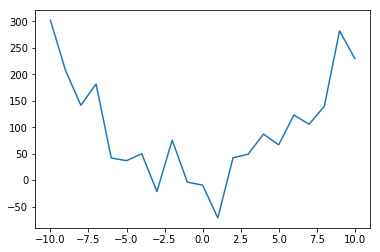

In [38]:
Unknown = pd.read_csv("data/UnbekannteDaten.txt", sep=" ")
plt.plot(Unknown['y'], Unknown['x'])

Mittels der `polyfit` Funktion lassen sich relativ einfach die Koeffizienten für eine Approximation finden. Über die Summe der Residuen lässt sich das beste Polynom finden.

None

Fehler der Residuen: 7.3461139803982615e-06 für Polynom 20.Grades


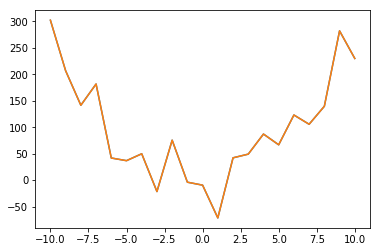

In [106]:
from IPython import display
stdErrFn = lambda  fittet_list: math.sqrt(sum([(x-y)**2 for x, y in zip(fittet_list, Unknown['x'])]))

i = 1
se = float("inf")
se_accept = 0.01
while se > se_accept:
    fit = pylab.polyfit(Unknown['y'], Unknown['x'], i)
    fit_fn = pylab.poly1d(fit)
    se = stdErrFn(fit_fn(Unknown['y']))
    display.clear_output(wait=True)
    display.display(plt.gcf().clear())
    print ('Fehler der Residuen: ' + str(stdErrFn(fit_fn(Unknown['y']))) + ' für Polynom ' + str(i) + '.Grades')
    plt.plot(Unknown['y'], fit_fn(Unknown['y']))
    plt.plot(Unknown['y'], Unknown['x'])
    plt.show()
    time.sleep(1)
    i += 1


## Aufgabe 1 C - Federkonstanten

Einlesen der Federdaten und Darstellung der Auslenkung der Feder abhängig vom befestigten Gewicht

In [8]:
SpringData = pd.read_csv("data/DatenFeder.txt", sep=" ")

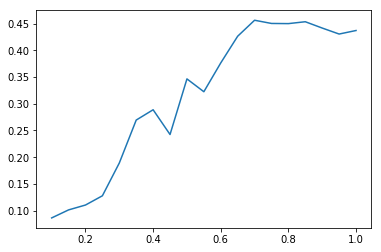

In [9]:
plt.plot(SpringData['Mass(kg)'], SpringData['Distance(m)'])

Schätzen eines Polynoms anhand der Federdaten, Polynom vom Grad 15 liefert ausreichende Annäherung.

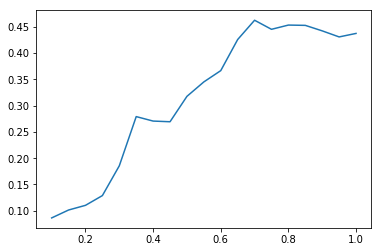

In [10]:
coefs = poly.polyfit(SpringData['Mass(kg)'], SpringData['Distance(m)'], 15)
ffit = poly.Polynomial(coefs)    # instead of np.poly1d
plt.plot(SpringData['Mass(kg)'], ffit(SpringData['Mass(kg)']))

Berechnung der Federkonstante über die Formel D = F/x für jeden Datenpunkt(Gewicht und Auslenkung der Feder). Aus den berechneten Federkonstanten wird der Mittelwert berechnet.

In [11]:
SpringConst = 0;
for i in range(0,19):
    Force = SpringData['Mass(kg)'][i] * 9.80665
    SpringConst = SpringConst + (Force / SpringData['Distance(m)'][i])
    #print((Kraft / FederData['Distance(m)'][i]))
SpringConst = SpringConst / 18
print('Die gemittelte Federkonstante aus linearer Funktion ist: ' + str(SpringConst))

Die gemittelte Federkonstante aus linearer Funktion ist: 17.52992822622751


In [12]:
D = poly.polyfit(SpringData['Distance(m)'][0:19],SpringData['Mass(kg)'][0:19] * 9.80665,3);
D   #????

array([ -0.48227382,  25.28945829, -56.61591371,  96.29927373])

## Aufgabe 1 D - Wurfbewegung

Einlesen der Daten eines geworfenen Balls, der in bestimmten Abständen in Höhe und Distanz beobachtet wurde. Umrechnung der Einheiten von yds in Meter.

In [13]:
ThrowData = pd.read_csv("data/DatenSchWurf.txt", sep=" ")
ThrowData = ThrowData * 0.9144
ThrowData

,Distance(yds),height(ins),height,height.1,height.2
0,27.4320,0.0000,0.0000,0.00000,0.0000
1,26.5176,2.0574,2.9718,4.11480,5.9436
2,25.6032,4.8006,5.9436,5.94360,8.0010
3,24.6888,6.8580,7.0866,7.54380,8.4582
4,23.7744,8.0010,8.4582,8.68680,9.6012
5,22.8600,10.9728,11.2014,11.43000,13.4874
6,21.9456,12.5730,14.6304,14.63040,15.0876
7,21.0312,13.4874,13.9446,14.17320,16.0020
8,20.1168,14.1732,14.6304,15.17904,15.3162
9,19.2024,15.5448,15.5448,16.00200,17.6022


Darstellung der Flugbahn des geworfenen Balls.

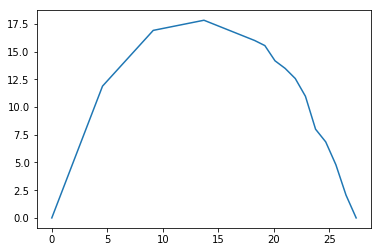

In [14]:
plt.plot(ThrowData['Distance(yds)'], ThrowData['height(ins)'])

Schätzen eines Polynoms durch lineare Regression aus den gegebenen Wurfdaten. Polynom vom Grad 2 ausreichend da Wurfform Parabelförmig.

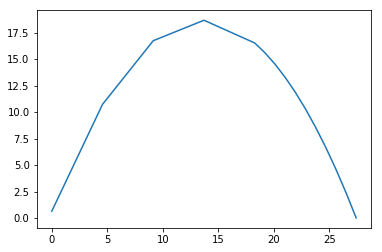

In [15]:
coeffs = poly.polyfit(ThrowData['Distance(yds)'],ThrowData['height(ins)'],2);
ffit = poly.Polynomial(coeffs)    # instead of np.poly1d
plt.plot(ThrowData['Distance(yds)'], ffit(ThrowData['Distance(yds)']))

Berechnung der Flugzeit über die ausschließliche Betrachtung des vertikalen freien Falls. Die Dauer des freien Falls vom höchsten Punkt der Flugbahn bis zum Boden wird über die Formel t = (s*2/g)^0.5 berechnet, wobei s die Höhe des freien Falls ist und g die Gravitationskonstante auf der Erde. Es wird, aufgrund der Parabelförmigen Flugbahn und der Annahme dass der Ball in gleichmäßigen Abständen beobachtet wurde, angenommen dass die Zeit vom Abwurf bis zum höchsten Punkt der Flugbahn in etwa gleichlang ist wie die in der der Ball fällt. Somit muss oben berechnete Zeit t verdoppelt werden um die gesamte Flugzeit zu erhalten.

In [16]:
#Dauer des Flugs: Freier Fall aus 20m Höhe Formel s = 1/2 g * t^2 
g = 9.81;
s = max(ThrowData['height(ins)']);
t=(s*2/g)**0.5
t = t * 2 #Ball fliegt in etwa in der gleichen Geschwindigkeit nach oben wie er wieder fällt
print('Die Flugzeit beträgt ca. ' + str(t) + ' Sekunden')


Die Flugzeit beträgt ca. 3.813255489892155 Sekunden


Die horizontale Geschwindigkeit wird aus der zurückgelegten Entfernung sowie der gerade berechneten Flugzeit berechnet.

In [17]:
#Geschwindigkeit in horzontaler Richtung
vHoriz = max(ThrowData['Distance(yds)']) / t
print('Die Horizontale Geschwindigkeit beträgt: ' + str(vHoriz) + ' m/s')

Die Horizontale Geschwindigkeit beträgt: 7.193853145354239 m/s


Die vertikale Fluggeschwindigkeit ist abhängig vom Zeitpunkt des Fluges. Sie wird wieder zunächst für den freien Fall über die Formel v = g * t berechnet. Durch die Parabelform wird angenommen, dass sich die Geschwindigkeit auf dem Flug von unten nach oben genauso verhalten hat wie beim freien Fall, die Werte werden also umgekehrt wie beim freien Fall hinzugefügt. 

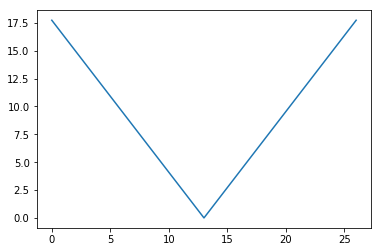

In [18]:
step = t / max(ThrowData['Distance(yds)'])
g = 9.81
v = []
vDown = []
vUp = []
for i in range(0, 14):
    vDown.append(g*(step * i))
vUp = vDown[::-1]
vUp.pop()
v = vUp + vDown
plt.plot(range(0,27), v)

